In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Fri Jan 12 00:12:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-5/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 343800
-rw-rw-r-- 1 scpark scpark  1236740  1월 12 00:12 events.out.tfevents.1704985349.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 12 00:10 save_10000
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:02 save_0
-rw-rw-r-- 1 scpark scpark   791876  1월 12 00:02 events.out.tfevents.1704984938.GPUSVR01
-rw-rw-r-- 1 scpark scpark   392708  1월 11 23:55 events.out.tfevents.1704984728.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1111844  1월 11 22:02 events.out.tfevents.1704977565.GPUSVR01
-rw-rw-r-- 1 scpark scpark   956624  1월 11 21:52 events.out.tfevents.1704977070.GPUSVR01
-rw-rw-r-- 1 scpark scpark  5403856  1월 11 21:44 events.out.tfevents.1704974497.GPUSVR01
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:40 save_50000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:32 save_40000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:24 save_30000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:16 save_20000
-rw-rw-r-- 1 scpark scpark   477776  1월 11 21:01 events.out.tfevents.1704974263.GPUSVR01
-rw-rw-r

### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


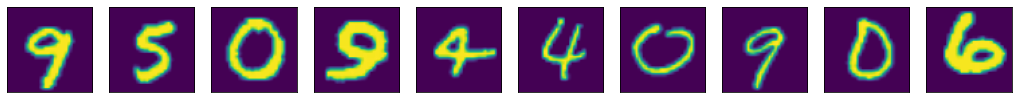

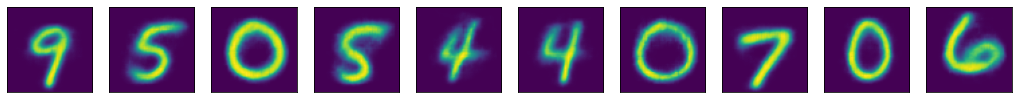

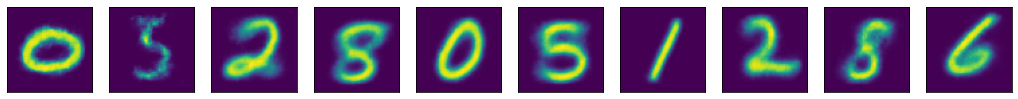

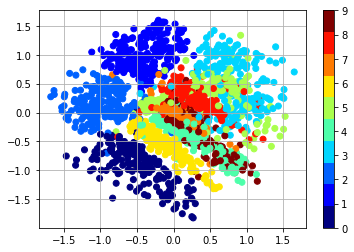

50001
lse_loss -3.386378765106201
recon_loss 0.09153478592634201
50002
lse_loss -3.4014272689819336
recon_loss 0.09525441378355026
50003
lse_loss -3.4036753177642822
recon_loss 0.0995989441871643
50004
lse_loss -3.3982982635498047
recon_loss 0.09340336173772812
50005
lse_loss -3.4267187118530273
recon_loss 0.09545352309942245
50006
lse_loss -3.38809871673584
recon_loss 0.10155387967824936
50007
lse_loss -3.4059951305389404
recon_loss 0.09353993833065033
50008
lse_loss -3.3895373344421387
recon_loss 0.08487457036972046
50009
lse_loss -3.3975086212158203
recon_loss 0.0996386855840683
50010
lse_loss -3.388974905014038
recon_loss 0.08993004262447357
50011
lse_loss -3.383134365081787
recon_loss 0.10276876389980316
50012
lse_loss -3.3982038497924805
recon_loss 0.09164965152740479
50013
lse_loss -3.4047462940216064
recon_loss 0.096134714782238
50014
lse_loss -3.4115452766418457
recon_loss 0.10884524881839752
50015
lse_loss -3.3939146995544434
recon_loss 0.0922747552394867
50016
lse_loss -3.39

50131
lse_loss -3.4018826484680176
recon_loss 0.09386873245239258
50132
lse_loss -3.3973381519317627
recon_loss 0.09971021115779877
50133
lse_loss -3.383502960205078
recon_loss 0.09910744428634644
50134
lse_loss -3.4174091815948486
recon_loss 0.09426926076412201
50135
lse_loss -3.4003748893737793
recon_loss 0.09021323919296265
50136
lse_loss -3.402155876159668
recon_loss 0.10621929168701172
50137
lse_loss -3.376668691635132
recon_loss 0.08992277085781097
50138
lse_loss -3.4092953205108643
recon_loss 0.09262681007385254
50139
lse_loss -3.3879482746124268
recon_loss 0.09201347827911377
50140
lse_loss -3.416649103164673
recon_loss 0.09470419585704803
50141
lse_loss -3.4045000076293945
recon_loss 0.10260318219661713
50142
lse_loss -3.418091297149658
recon_loss 0.08864497393369675
50143
lse_loss -3.398089647293091
recon_loss 0.09598919004201889
50144
lse_loss -3.41477108001709
recon_loss 0.08728832006454468
50145
lse_loss -3.4279069900512695
recon_loss 0.10907425731420517
50146
lse_loss -3.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=8e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        